In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

In [3]:
# Add an additional column, mapping to the type
df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [5]:
df.columns

Index(['id_code', 'diagnosis', 'binary_type', 'type'], dtype='object')

In [9]:
df['type'].value_counts()

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: type, dtype: int64

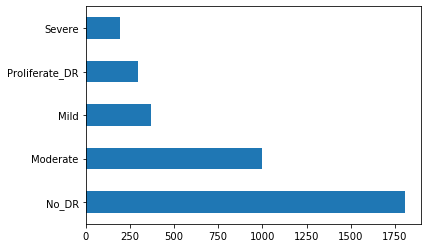

In [10]:
df['type'].value_counts().plot(kind='barh')

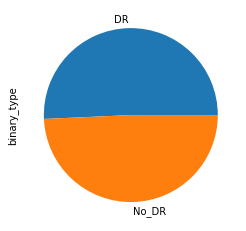

In [12]:
df['binary_type'].value_counts().plot(kind='pie')

In [14]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("Train")
print(train['type'].value_counts(), '\n')
print("Valid")
print(val['type'].value_counts(), '\n')
print("Test")
print(test['type'].value_counts(), '\n')

Train
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

Valid
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

Test
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [15]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [16]:
# Copy images to respective working directory
src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [17]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

# pixel is smallest element in image...contains color infos...RGB na grayscale mode values
# RGB mode image value point ranges from 0 to 255...so, rescaled them to 0 to 1 value by dividing by 1/255
# rescaling is a simple form of data normalization or preprocessing

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [18]:
os.listdir('/kaggle/working/train')

['Moderate', 'Mild', 'Proliferate_DR', 'No_DR', 'Severe']

# 8 Layer CNN Model

In [19]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(16, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding="same", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(1,1)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc','AUC',tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

history = model.fit(train_batches,
                    epochs=12,
                    validation_data=val_batches)

Train for 81 steps, validate for 18 steps
Epoch 1/12
81/81 [==============================] - 15s 191ms/step - loss: 0.4468 - acc: 0.8162 - AUC: 0.7313 - f1_score: 0.4303 - cohen_kappa: 0.1632 - val_loss: 0.4951 - val_acc: 0.8000 - val_AUC: 0.4785 - val_f1_score: 0.0119 - val_cohen_kappa: 0.0000e+00
Epoch 2/12
81/81 [==============================] - 10s 129ms/step - loss: 0.3810 - acc: 0.8426 - AUC: 0.8193 - f1_score: 0.5282 - cohen_kappa: 0.2993 - val_loss: 0.4830 - val_acc: 0.8000 - val_AUC: 0.7289 - val_f1_score: 0.2767 - val_cohen_kappa: -0.1704
Epoch 3/12
81/81 [==============================] - 11s 135ms/step - loss: 0.3495 - acc: 0.8553 - AUC: 0.8526 - f1_score: 0.5486 - cohen_kappa: 0.3315 - val_loss: 0.4709 - val_acc: 0.8000 - val_AUC: 0.7446 - val_f1_score: 0.3221 - val_cohen_kappa: -0.0111
Epoch 4/12
81/81 [==============================] - 11s 130ms/step - loss: 0.3310 - acc: 0.8607 - AUC: 0.8702 - f1_score: 0.5681 - cohen_kappa: 0.3617 - val_loss: 0.4682 - val_acc: 0.8000

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9

In [20]:
acc = model.evaluate_generator(test_batches, verbose=1)
print("Accuracy: ", acc[1])

18/18 [==============================] - 2s 100ms/step - loss: 0.3206 - acc: 0.8840 - AUC: 0.8875 - f1_score: 0.6341 - cohen_kappa: 0.4842
Accuracy:  0.8839999


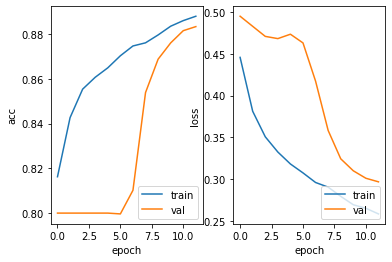

In [22]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')


In [23]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Mild', 'Moderate', 'Mild', 'Moderate', 'Moderate']
